# Markov chain Monte Carlo–based Bayesian data analysis for type Ia Supernovae 

Author: Olesya Galkina

Markov chain Monte Carlo (MCMC) and Bayesian statistics are two independent disciplines, the former being a method to sample from a distribution while the latter is a theory to interpret observed data.

O que é H_0

O que é Hubble tension ou Crise cosmológica. 
In recent years, the tension between different measurements of H_0 has garnered significant attention. While the Planck satellite mission, which analyzed the CMB, reported a value of H_0 around 67 km/s/Mpc, independent measurements using the local distance ladder technique, such as the SH0ES collaboration, have consistently obtained higher values, closer to 73 km/s/Mpc. This discrepancy, significant at the 5σ level and often referred to as the “Hubble tension,” has led to considerable interest in exploring cosmological models that can reconcile these conflicting results.

In [1]:
import pandas as pd
import numpy as np
import math

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import constants

# For analysing Monte Carlo samples
import emcee
from emcee import EnsembleSampler

# For plotting Monte Carlo samples
import getdist
from getdist import plots

In this work we use the latest data from the Pantheon+SH0ES collaboration that provides $1701$ light curve measurements of $1550$ Supernova objects. The data set is available [here](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main).

In [2]:
# Load the data

file_path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES.dat"
df = pd.read_csv(file_path, delimiter='\s+')

df.shape

(1701, 47)

In [3]:
df.head(10)

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006
5,1981B,50,0.00317,0.00084,0.00350,0.00001,0.00236,0.00001,11.54160,0.613941,...,0.2973,41,43.2260,0.376420,0.0732,0.5763,0.0206,0.007,1.0,0.013
6,2013aa,56,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.20740,0.594070,...,0.1580,31,27.5263,0.645500,0.1104,0.5586,0.0298,0.003,1.0,0.003
7,2013aa,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.29980,0.579622,...,0.1190,56,35.0505,0.987280,0.0620,0.5586,0.0727,0.007,1.0,0.003
8,2017cbv,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.14830,0.577815,...,0.0381,94,69.7345,0.971300,0.0580,0.5586,0.0516,0.004,1.0,0.003
9,2017cbv,18,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.25770,0.577916,...,0.0500,92,45.1690,0.999990,0.0607,0.5586,0.0216,0.003,1.0,0.003


We are interested in following parameters:

 - `zHD` Hubble Diagram Redshift $z$ (with CMB and VPEC corrections)  
 - `zHDERR` Hubble Diagram Redshift Uncertainty
 - `zHEL` heliocentric redshift $z_{hel}$
 - `zHELERR` heliocentric redshift uncertainty
 - `m_b_corr` corrected apparent $m_b$ magnitude.
 - `m_b_corr_err_DIAG` corrected $m_b$ magnitude uncertainty as determined from the diagonal of the covariance matrix. 

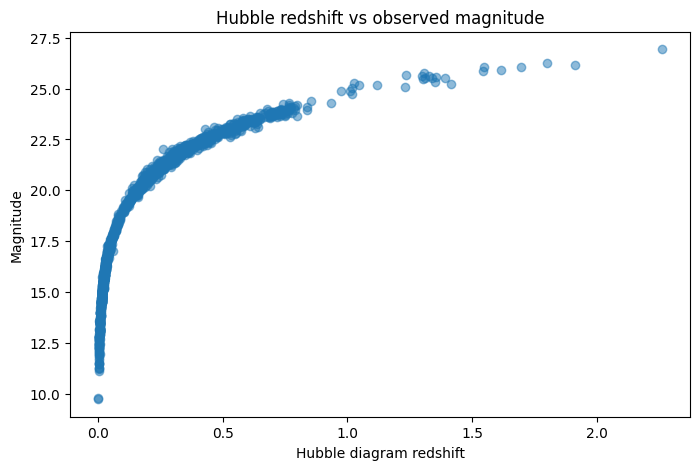

In [4]:
# Plot observed CMB corrected redshift vs observed magnitude

plt.figure(figsize=(8, 5))
plt.scatter(df['zHD'], df['m_b_corr'], alpha=0.5)
plt.title('Hubble redshift vs observed magnitude')
plt.xlabel('Hubble diagram redshift')
plt.ylabel('Magnitude')
plt.grid(False)

plt.show()

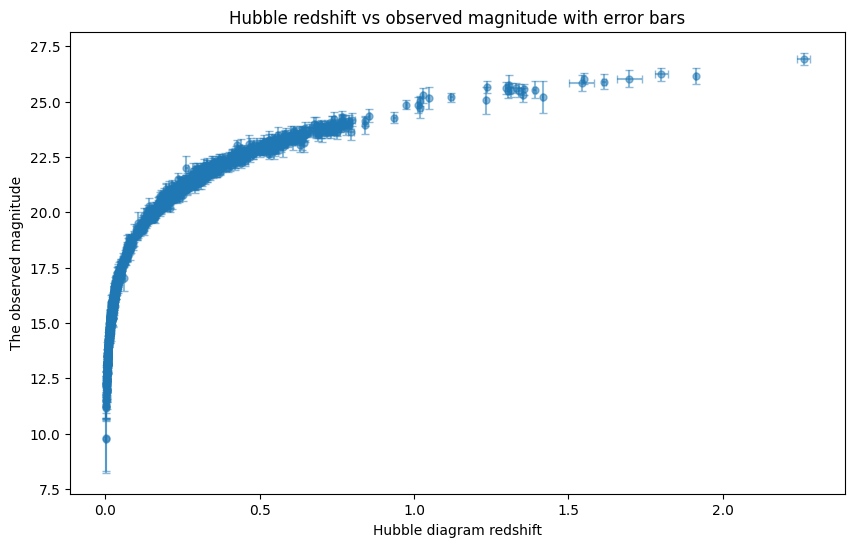

In [6]:
# Plot with error bars

plt.figure(figsize=(10, 6))
plt.errorbar(df['zHD'], df['m_b_corr'], xerr=df['zHDERR'], yerr=df['m_b_corr_err_DIAG'], fmt='o', alpha=0.5,
             capsize=3, markersize=5)
plt.title('Hubble redshift vs observed magnitude with error bars')
plt.xlabel('Hubble diagram redshift')
plt.ylabel('The observed magnitude')
plt.grid(False)

plt.show()

In our work we are interested in the Hubble constant $H_0$ in the redshift range $0.023<z<0.15$, we select the range and save it as numpy array.
EXPLICAR

In [7]:
# Verify the total range

print('The Hubble diagram redshift range is: ', df['zHD'].min(), '< z <', df['zHD'].max())

The Hubble diagram redshift range is:  0.00122 < z < 2.26137


In [8]:
# Assign values in the selected range to 'z-values' using a boolean mask

z_values = df.loc[(df['zHD'] > 0.023) & (df['zHD'] < 0.15), 'zHD'].to_numpy()

z_values.shape

(496,)

We have $496$ values out of $1701$ in this range.

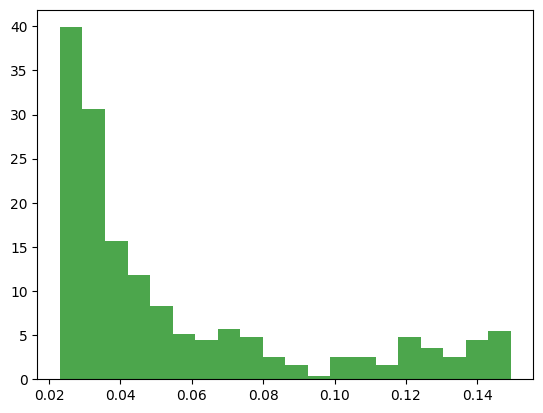

In [9]:
data = df.loc[(df['zHD'] > 0.023) & (df['zHD'] < 0.15), 'zHD']
num_bins = 20
n, bins, patches = plt.hist(data, num_bins, 
                            density = 1, 
                            color ='green',
                            alpha = 0.7)
plt.show()

Let's select others parameters in this range.

In [10]:
# Selects values from specific columns 

def select_values_in_range(df, column_name, lower_bound, upper_bound, other_columns):
    selected_rows = df.loc[(df[column_name] > lower_bound) & (df[column_name] < upper_bound)]
    selected_values = selected_rows[other_columns]
    
    return selected_values

In [11]:
# Define the columns we want to select

other_columns = ['zHDERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG']  

In [12]:
# Call the function

selected_values = select_values_in_range(df, 'zHD', 0.023, 0.15, other_columns)
selected_values

,zHDERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG
330,0.00086,0.02341,0.00009,15.7320,0.188819
331,0.00086,0.02338,0.00006,15.5136,0.339266
332,0.00085,0.02233,0.00004,15.7695,0.269874
333,0.00087,0.02315,0.00015,15.6300,0.273642
334,0.00085,0.02237,0.00001,15.6638,0.176470
...,...,...,...,...,...
821,0.00108,0.14896,0.00050,19.9755,0.183004
822,0.00096,0.14927,0.00004,19.7852,0.155606
823,0.00108,0.14915,0.00050,19.7709,0.140105
824,0.00096,0.15021,0.00002,19.9076,0.172844


### The luminosity distance

The luminosity distance is a very important notion of distance for observation. It is based on the knowledge of the intrinsic luminosity _L_ of a source, which is therefore called _standard candle_. Type Ia supernovae are standard candles, for example.


The luminosity distance $d_{L}(z, z_{hel})$ in a flat expanding Friedmann-Lemaitre-Robertson-Walker universe is defined as:
$$
d_{L}(z, z_{hel})=\frac{1+z_{hel}}{1+z}d_L(z),
$$
with

$$
d_{L}(z)=\frac{c}{H_0}\left[z+\frac{1}{2}(1-q_0)z^2-\frac{1}{6}(3q_0^2+q_0-j_0-1)(z^3)\right], 
$$

where $z_{hel}$  is heliocentric redshift, $H_0$ is the Hubble constant, $q_0$ is a deceleration parameter and $j_0$ is a "jerk parameter" (third order derivative parameter).

Let's calculate the luminosity distance (up to second order) assuming the value of the Hubble constant $H_0$ as measured by the _SH0ES_ collaboration and the following parameters:

We use NumPy to perform vectorized operations and avoid using explicit loops.

In [23]:
# Function to calculate the luminosity distance d_L(z) 
cc = constants.c/1000.
j0 = 1

def lum_distance(z,H0,q0):
    dL = cc*z*(1+(1-q0)*(z/2)+(3*q0**2+q0-j0-1)*((z**2)/6))/H0
    return dL

In [24]:
# Transform selected_values['zHEL'] to NumPy array

z_hel = selected_values['zHEL'].to_numpy()

In [25]:
# Calculate the luminosity distance d_L(z,z_hel)

def lum_distance_total(z,z_hel,H0,q0):
    dL_total = ((1+z_hel)/(1+z)) * lum_distance(z,H0,q0)
    return dL_total

In [26]:
#check

lum_distance_total(z_values,z_hel,73,-0.55)

array([ 96.28843924,  96.45197073,  96.6022792 ,  96.80449491,
        96.93842028,  97.19007828,  97.3033862 ,  97.3033862 ,
        97.78210935,  97.78210935,  97.78210935,  97.84277971,
        97.84277971,  97.97336502,  98.29249788,  98.45544182,
        98.58698008,  98.58698008,  98.41945269,  98.81352513,
        99.01651882,  99.90483954,  99.87188633,  99.8679815 ,
        99.9671592 , 100.50260565, 100.86374068, 100.86374068,
       100.7841722 , 101.04919682, 101.04919682, 101.50454643,
       101.51635872, 101.62018366, 101.62018366, 101.77811316,
       101.69732353, 102.69410204, 102.69410204, 102.69410204,
       102.78135015, 102.8998482 , 102.8998482 , 102.8998482 ,
       102.94875489, 102.94875489, 103.25642391, 104.29217746,
       104.29790601, 105.02200486, 105.16304201, 105.16304201,
       105.0851465 , 105.16304201, 105.03915386, 105.2089984 ,
       105.27374765, 105.27374765, 105.27374765, 105.37028773,
       105.37028773, 105.57596527, 105.61672671, 105.61

### The distance modulus

The distance modulus $\mu$ of a supernova at redshift $z$ is defined as:

$$
\mu=m_B-M_B=5\log_{10}\left(\frac{d_{L}(z,z_{hel})}{1 Mpc}\right)+25,
$$

where $m_B$ is apparent magnitude and $M_B$ is the absolute magnitude (the hypothetical apparent magnitude of an object as if it were at a distance of $10$ $pc$). We use the Megaparsec ($Mpc$) as a more appropriate distance scale for cosmology.

In [27]:
# Transform selected_values['m_b_corr'] to NumPy array

m_data = selected_values['m_b_corr'].to_numpy()
print(m_data.shape)

(496,)


In [28]:
# Function to calculate the magnitude m_B

def magnitude(z, z_hel, H0, q0, M_B=-19.258):
    lum_dist = lum_distance_total(z, z_hel, H0, q0)
    m_B = 5 * np.log10(lum_dist) + 25 + M_B
    return m_B

### Chi-square $\chi^2$ statistic


The $\chi^2$ function defined as

$$
\chi^2_{sne}(H_0,q_0,j_0)=\left[\mu_{i,data}-\mu_{model}(z_i)\right]\Sigma^{-1}_{sne,ij}\left[\mu_{j,data}-\mu_{model}(z_j)\right],
$$

where $\mu_{i,data}$ and $\mu_{model}(z_i)$ are the _observed_ and _predicted_ distance moduli at the redshift $z_i$, respectively; $\Sigma^{-1}_{sne,ij}$ is the supernova covariance matrix from the Pantheon+ SH0ES collaboration (considering both statistical and systematic errors). First, we explore the covariance matrix.


#### Covariance matrix

The format of the covariance (.cov) file is NxN lines, where the first line gives the number of rows/columns in the matrix ($N=1701$). We are interested in the Statistical+Systematic covariance matrix `STAT+SYS`, it includes all the covariance between SNe (and also Cepheid host covariance) due to systematic uncertainties. Let's import the matrix and transform it into a Numpy array format.

In [29]:
# Load the covariant matrix

path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES_STAT+SYS.cov"
cov_matrix = np.loadtxt(path)
n_sne = int(cov_matrix[0])
cov_matrix = cov_matrix[1:].reshape((n_sne, n_sne))

In [30]:
cov_matrix.shape

(1701, 1701)

In [31]:
# Get the indices of z_values in the original dataframe
selected_indices = df[(df['zHD'] > 0.023) & (df['zHD'] < 0.15)].index

# Select the corresponding rows and columns from the covariance matrix
cov_matrix_selected = cov_matrix[selected_indices][:, selected_indices]

# Verify the shape of the selected covariance matrix
cov_matrix_selected.shape

(496, 496)

## Likelihood

We define the likelihood $\mathcal{L}_{sne}$ using the $\chi^2$ :

$$
\mathcal{L}_{sne}(H_0,q_0,j_0)=\mathcal{N}e^{-\frac{1}{2}\chi^{2}},
$$

where $\mathcal{N}=|2\pi\Sigma_{sne}|^{-\frac{1}{2}}$ is a normalization constant. The likelihood represents the probability of having a dataset given a cosmological model. We are interested in the contrary, i.e.
in the probability of having a certain cosmological model given a dataset. This is called **posterior probability**. 

Let's compute the Gaussian log-likelihood for the _observed_ and _predicted_ apparent magnitude at the redshifts $z_i$ e $z_{hel}$. For now, we omit the normalization constant.

In [32]:
# Calculate the inverse of the covariance matrix  

cov_inv = np.linalg.inv(cov_matrix_selected)

In [33]:
# Function to compute the logarithm of the likelihood
# Input: vector of parameters H0, parameters q_0 and j_0
# Output: the value of the likelihood at the specified parameter values

def log_likelihood(parameters):
    M_B, H0, q0 = parameters
    m_modelo = magnitude(z_values, z_hel, H0, q0) #Calculate model magnitudes for observed data
    diff = m_data - m_modelo #residuals
    diff = np.array(diff)
    log_likelihood_values = -0.5 * np.dot(diff, np.dot(diff, cov_inv))
    
    return log_likelihood_values

In [34]:
# Check the function

parameters = [-19.3,73,-0.55]
log_likelihood(parameters)

-217.76527386293392

In [35]:
# Fix the parameters 

q0_fix = -0.55

H0_range = np.linspace(65,85,25)
#log_likelihood = np.vectorize(log_likelihood)

### Posterior probability 

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo (MCMC) method. MCMC is a method for fitting models to data. 

According to Bayes Theorem, the posterior probability is given by

$$ 
P(\theta|d) = \frac{P(d|\theta)P(\theta)}{P(d)}, 
$$

where:
- $\theta$ is the cosmological parameters and  $d$ is the observed data, or samples. 
- $P(\theta|d)$ is the posterior probability for $\theta$, and it represents our degree of belief about the value of $\theta$ after we have seen the data $d$. 
- $P(d|\theta)=\mathcal{L}(\theta)$ is the likelihood function we already encountered. It is the probability of the data given a certain value of the parameters.
- $P(\theta)$ is the prior probability distribution. It represents our degree of belief in the value of $\theta$ before we see the data (hence the name).
- $P(d)$ is a normalizing constant, or the evidence, it ensures that the posterior is normalized to unity:$$ P(d)=\int d \theta P(d|\theta)P(\theta).$$


In our case, the posterior probability for $H_0$, $q_0$ and $j_0$ is given by
$$ 
P(H_0,q_0,j_0|SN) = \frac{P(H_0)P(q_0)P(j_0)\mathcal{L}((H_0,q_0,j_0))}{\mathcal{E}}, 
$$

where $\mathcal{E}$ is the evidence.

From now on, we use logarithm of probabilities to compute the log of posterior probability.

The log-prior probability is assumed to be zero if all the parameters are within their bounds and $-\infty$ if any of the parameters are outside their bounds.

In [36]:
# Compute the logarithm of the prior probability
# Input: H0 vector of parameters, parameters q_0 and j_0
# Output: the value of the prior at the specified parameter values

def log_uniprior(parameters):
    M_B, H0, q0 = parameters
    if (65 < H0 < 85) and (-10 < q0 < 10):
        return 0.0
    return -np.infty

In [37]:
parameters = [-19.3,73,-0.55]
log_uniprior(parameters)

0.0

In [38]:
# Compute log_normal prior
# Input: H0 vector of parameters, parameters q_0 and j_0
# Output: the value of the posterior at the specified parameter values

def log_normal(parameters):
    M_B, H0, q0 = parameters
    mu = -19.258    #mean value
    sigma = 0.032   #standard deviation
    log_prior = -0.5 * ((M_B - mu) / sigma)**2 
    return log_prior 

In [39]:
parameters = [-19.23,73,-0.55]
log_normal(parameters)

-0.38281249999996425

The posterior distribution combines the uniprior, gaussian prior and the likelihood. It outputs negative infinity if the parameters lie outside the range of the prior.

In [40]:
# Compute log_posterior 
# Input: vector of parameters
# Output: the value of the posterior at the specified parameter values

def log_posterior(parameters):
    M_B, H0, q0 = parameters
    lu = log_uniprior(parameters)
    normal = log_normal(parameters)
    if not (np.isfinite(lu) and np.isfinite(normal)):
        return -np.inf
    return log_likelihood(parameters) + lu + normal

In [41]:
parameters = [-19.3,73,-0.55]
log_posterior(parameters)

-218.62660198793398

The purpose of a Markov chain Monte Carlo algorithm is to construct a sequence of points (or “samples”) in parameter space (called “a chain”). The crucial property of the chain is that the density of samples is proportional to the posterior pdf. This allows to construct a map of the posterior distribution.

To sample the posterior we use `emcee`, an open-source sampler for MCMC, and for analyzing the chains we use `getdist`. `emcee` requires a function that returns the log-posterior probability.

First, we define two key variables: `ndim` and `nwalkers`. The `nwalkers` variable is the number of "walkers" (different Markov Chains that run in parallel). 

In [42]:
# Set initial parameters
initial_parameters = [-19.3, 73.04, q0_fix]  

nwalkers = 10
nsteps = 20000

# Generate initial values for each walker
initial_positions = [initial_parameters + 1e-4*np.random.randn(3) for _ in range(nwalkers)]

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, len(initial_parameters), log_posterior)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

# Get Markov chains
samples = sampler.get_chain()

# Print the results
print("Samples shape:", samples.shape)


100%|██████████| 20000/20000 [02:47<00:00, 119.57it/s]

Samples shape: (20000, 10, 3)


The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. In fact, after fewer than 50 steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time:

In [43]:
tau = sampler.get_autocorr_time()
print(tau)

[46.55360685 44.77817085 46.49987295]


This suggests that about 45 steps are needed for the chain to “forget” where it started.

## Results

Now we have the list of samples, let’s make a corner plot. 

Removed no burn in


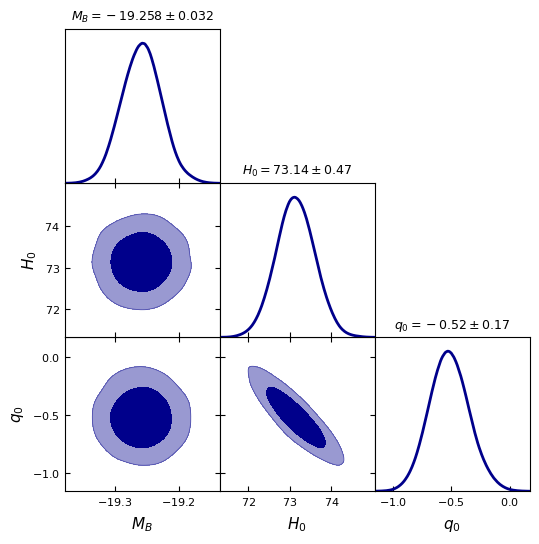

In [44]:
# Get the samples
samples = sampler.get_chain(discard=2000, thin=15, flat=True) 

# Set labels for parameters
param_names = ['M_B', 'H_0', 'q_0']

# Create an MCSamples object with the samples
mcsamples = getdist.MCSamples(samples=samples, names=param_names, labels=param_names)

# Plot the triplot
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 12
g.triangle_plot(mcsamples, filled=True, line_args=[{'lw':2, 'color':'darkblue'}], 
                contour_colors=['darkblue'], title_limit=1)

g.set_axes(labelLines = param_names)

plt.show()
g.export('triplot.png')

In [45]:
marg = mcsamples.getMargeStats()
print(marg)

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
M_B        -1.9258324E+01  3.1575672E-02 -1.9290057E+01 -1.9227067E+01  two   -1.9319649E+01 -1.9195225E+01  two   -1.9340538E+01 -1.9174685E+01  two     M_B
H_0         7.3138458E+01  4.7105320E-01  7.2676674E+01  7.3609136E+01  two    7.2212653E+01  7.4058905E+01  two    7.1906671E+01  7.4367957E+01  two     H_0
q_0        -5.1772547E-01  1.7193799E-01 -6.8868167E-01 -3.4817621E-01  two   -8.4553302E-01 -1.6958020E-01  two   -9.4814616E-01 -5.8392124E-02  two     q_0



The corner plot shows all the one and two dimensional projections of the posterior probability distributions of the parameters. And it demonstrates all of the covariances between parameters. 

The uncertainties based on the 68th, 95th, and 99.7 percentiles of the samples in the marginalized distributions: 

In [46]:
from IPython.display import display, Math

labels=param_names

for i in range(3):
    mcmc = np.percentile(samples[:, i], [68, 95, 99.7])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Autocorrelation analysis and convergence

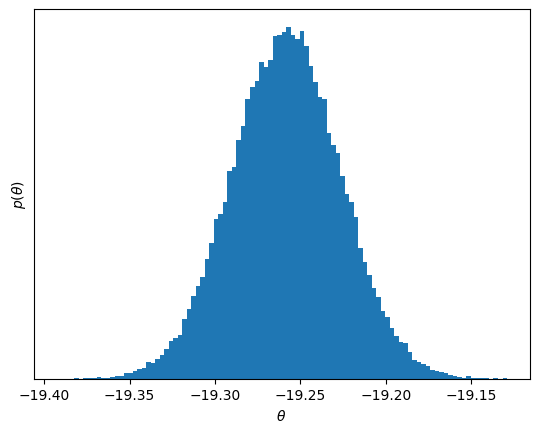

In [47]:
# Marginalized density in the first dimension

chain = sampler.get_chain()[:, :, 0].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

In [48]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

In [49]:
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

In [50]:
# Automated windowing procedure following Sokal (1989)

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

In [51]:
# Following the suggestion from Goodman & Weare (2010)

def autocorr_gw2010(y, c=5):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2 * np.cumsum(f) - 1
    window = auto_window(taus, c)
    return taus[window]

In [52]:
def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2 * np.cumsum(f) - 1
    window = auto_window(taus, c)
    return taus[window]

In [53]:
# Compute the estimators for a few different chain lengths

N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

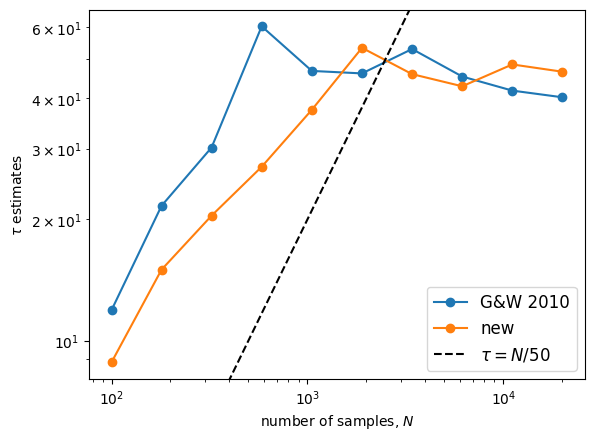

In [54]:
# Plot the comparisons

plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
#plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=12);

## References

[1] D. Scolnic, D. Brout, A. Carr, A. G. Riess, T. M. Davis, A. Dwomoh, D. O. Jones, N. Ali, P. Charvu and R. Chen, et al. _The Pantheon+ Analysis: The Full Data Set and Light-curve Release_, Astrophys. J. 938 (2022).

[1] David Camarena and Valerio Marra, _Local determination of the Hubble constant and the deceleration parameter_, Phys. Rev. Research 2, 013028 (2020).


[2] Oliver Piattella, _Lecture Notes in Cosmology_, Springer Cham (2018). 


[3] D. Foreman-Mackey, D. W. Hogg, D. Lang, and J. Goodman, _emcee: The MCMC Hammer_, Publ. Astron. Soc. Pac. 125 (2013) 306–312, https://arxiv.org/abs/1202.3665


[4] A. Lewis, _GetDist: a Python package for analysing Monte Carlo samples_, arXiv:1910.13970, https://getdist.readthedocs.io.